Mounted at /content/drive
Processing PAMAP2 dataset...
Common activities: [4, 17, 1, 3, 7, 2, 16, 6]
Data shape after filtering: (1573153, 55)
Creating irregularly sampled time series...
Created 5146 samples with 52 variables
Number of classes: 8
Train: 3602, Val: 771, Test: 773
Saving processed data to /content/processed_PAM
Dataset processed and saved
Using device: cuda
Loading PAM dataset...
PAM dataset loaded: 5146 samples
Number of variables: 52
Train: 3602, Val: 771, Test: 773
Number of classes: 8


Downloading: "https://download.pytorch.org/models/swin_t-704ceda3.pth" to /root/.cache/torch/hub/checkpoints/swin_t-704ceda3.pth
100%|██████████| 108M/108M [00:00<00:00, 177MB/s] 
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Visualizing time series images...


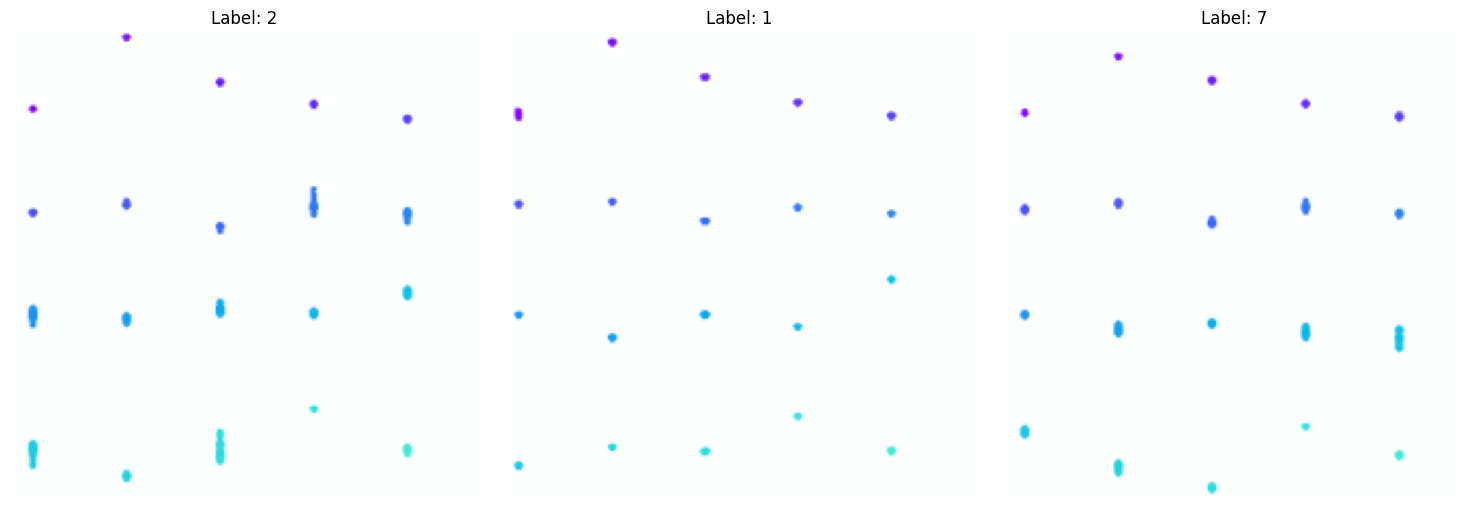

Starting training...
Epoch 1/10
  Batch 10/113, Loss: 2.0318
  Batch 20/113, Loss: 1.8410
  Batch 30/113, Loss: 1.5464
  Batch 40/113, Loss: 1.3512
  Batch 50/113, Loss: 1.4655
  Batch 60/113, Loss: 1.3674
  Batch 70/113, Loss: 1.0526
  Batch 80/113, Loss: 1.0844
  Batch 90/113, Loss: 0.8343
  Batch 100/113, Loss: 0.6929
  Batch 110/113, Loss: 0.5450
Train Loss: 1.2873
Validation Metrics: {'accuracy': 0.8975356679636836, 'precision': 0.9018362977663484, 'recall': 0.8945829689082685, 'f1': 0.8957167220778575}
Best model saved with F1 score: 0.8957
Epoch 2/10
  Batch 10/113, Loss: 0.5437
  Batch 20/113, Loss: 0.2366
  Batch 30/113, Loss: 0.3681
  Batch 40/113, Loss: 0.4291
  Batch 50/113, Loss: 0.2387
  Batch 60/113, Loss: 0.2096
  Batch 70/113, Loss: 0.2478
  Batch 80/113, Loss: 0.2658
  Batch 90/113, Loss: 0.1743
  Batch 100/113, Loss: 0.2603
  Batch 110/113, Loss: 0.1196
Train Loss: 0.3097
Validation Metrics: {'accuracy': 0.9546044098573282, 'precision': 0.9544297027457773, 'recall': 

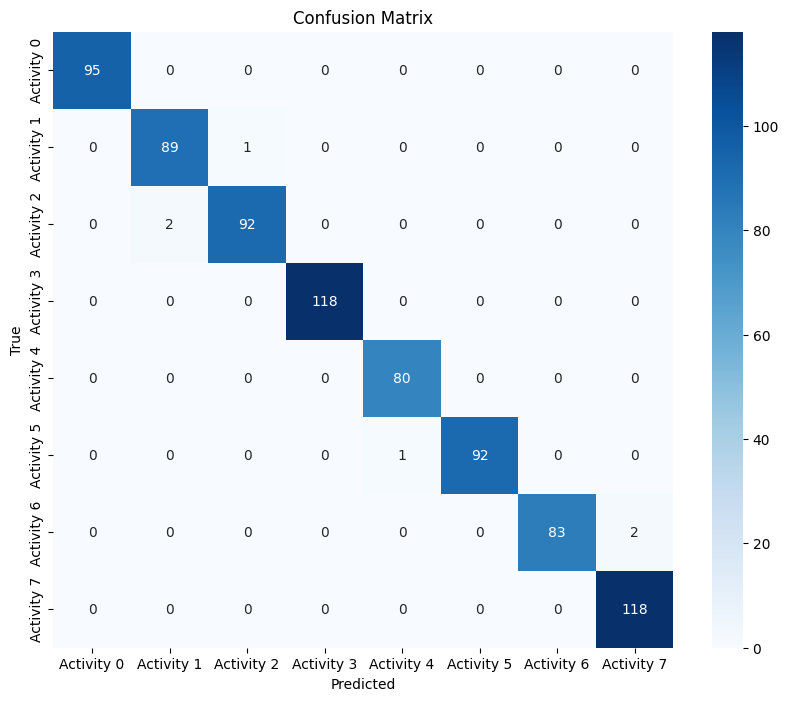

Results saved to /content/drive/MyDrive/ViTST/results.json


In [ ]:
'''
# Vision Transformer for Irregularly Sampled Time Series (ViTST) - PAM Dataset Implementation
This notebook implements the approach from the paper "Time Series as Images: Vision Transformer for Irregularly Sampled Time Series"
'''

# Step 1: Install required packages
!pip install matplotlib numpy pandas torch torchvision scikit-learn pillow seaborn

# Step 2: Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import random
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
import pickle
import json
import seaborn as sns
from google.colab import drive
from sklearn.model_selection import train_test_split

# Step 3: Mount Google Drive for saving results
drive.mount('/content/drive')

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed()

# Set paths
PROCESSED_DATA_PATH = '/content/processed_PAM'
ORIGINAL_DATA_PATH = '/content/PAMAP2_Dataset'

# Part 1: Download and process the PAM dataset
def download_and_process_dataset():
    """Download and process the PAM dataset"""
    print("Downloading and processing PAM dataset...")

    # Create directory for processed data
    os.makedirs(PROCESSED_DATA_PATH, exist_ok=True)

    # Download the PAMAP2 dataset
    print("Downloading original PAMAP2 dataset...")
    !wget -q https://archive.ics.uci.edu/ml/machine-learning-databases/00231/PAMAP2_Dataset.zip
    !unzip -q PAMAP2_Dataset.zip -d /content

    # Create a synthetic dataset if download fails
    if not os.path.exists(f"{ORIGINAL_DATA_PATH}/Protocol"):
        print("Download failed or dataset structure is different. Creating synthetic data instead.")
        create_synthetic_pam_data()
        return

    # Process the dataset
    process_pamap2_dataset()

def create_synthetic_pam_data():
    """Create synthetic PAM data for demonstration"""
    print("Creating synthetic PAM data...")

    # PAM has 8 activity classes and 17 variables/sensors
    n_samples = 2000
    n_variables = 17
    n_classes = 8

    # Create synthetic data
    X_data = []
    y_data = np.random.randint(0, n_classes, n_samples)

    # Create patterns for each class to make classification more realistic
    patterns = [
        lambda t: np.sin(t/50),                           # Activity 0
        lambda t: np.sin(t/25),                           # Activity 1
        lambda t: np.sin(t/10),                           # Activity 2
        lambda t: np.cos(t/50),                           # Activity 3
        lambda t: np.cos(t/25),                           # Activity 4
        lambda t: np.cos(t/10),                           # Activity 5
        lambda t: np.sin(t/50) + np.cos(t/25),            # Activity 6
        lambda t: np.sin(t/25) + np.cos(t/10)             # Activity 7
    ]

    for i in range(n_samples):
        activity = y_data[i]

        # Generate sample
        sample = {'times': [], 'values': []}

        # Create data for each variable with the pattern of the assigned activity
        for var_idx in range(n_variables):
            # Max observations (as in the paper)
            max_obs = 600

            # Apply missing ratio of 60% as mentioned in the paper
            n_obs = int(max_obs * 0.4)

            # Generate random observation times
            times = np.sort(np.random.choice(np.arange(max_obs), n_obs, replace=False))

            # Generate values based on the activity pattern with some random noise
            base_pattern = patterns[activity](times)
            noise = np.random.normal(0, 0.1, n_obs)
            values = base_pattern + noise + var_idx/10  # Add offset for each variable

            sample['times'].append(times)
            sample['values'].append(values)

        X_data.append(sample)

    # Create train/val/test split
    train_ratio = 0.7
    val_ratio = 0.15

    # First split into train and temp
    X_train, X_temp, y_train, y_temp = train_test_split(
        list(range(n_samples)), y_data, test_size=(1-train_ratio), stratify=y_data, random_state=42
    )

    # Split temp into validation and test
    val_ratio_adjusted = val_ratio / (1 - train_ratio)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=(1-val_ratio_adjusted), stratify=y_temp, random_state=42
    )

    # Create indices
    indices = {
        'train_ind': X_train,
        'valid_ind': X_val,
        'test_ind': X_test
    }

    # Save the data
    print(f"Saving synthetic data to {PROCESSED_DATA_PATH}")
    with open(f'{PROCESSED_DATA_PATH}/X.pkl', 'wb') as f:
        pickle.dump(X_data, f)

    with open(f'{PROCESSED_DATA_PATH}/y.pkl', 'wb') as f:
        pickle.dump(y_data, f)

    with open(f'{PROCESSED_DATA_PATH}/ind.pkl', 'wb') as f:
        pickle.dump(indices, f)

    print(f"Synthetic dataset created with {n_samples} samples, {n_variables} variables, and {n_classes} classes")
    print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

def process_pamap2_dataset():
    """Process the real PAMAP2 dataset"""
    print("Processing PAMAP2 dataset...")

    # Define column names
    colnames = ['timestamp', 'activityID', 'heartrate']

    # IMU hand
    for i in range(1, 18):
        colnames.append(f'hand_IMU_{i}')

    # IMU chest
    for i in range(1, 18):
        colnames.append(f'chest_IMU_{i}')

    # IMU ankle
    for i in range(1, 18):
        colnames.append(f'ankle_IMU_{i}')

    # Load and preprocess the data
    protocol_path = f'{ORIGINAL_DATA_PATH}/Protocol'
    subject_files = [f for f in os.listdir(protocol_path) if f.startswith('subject')]

    all_data = []

    for file in subject_files:
        # Load the data
        file_path = os.path.join(protocol_path, file)
        data = pd.read_csv(file_path, sep=' ', header=None, names=colnames)

        # Add subject ID
        subject_id = int(file.replace('subject', '').replace('.dat', ''))
        data['subject_id'] = subject_id

        # Remove rows with activity ID 0 (transient activities)
        data = data[data['activityID'] != 0]

        all_data.append(data)

    # Concatenate all data
    combined_data = pd.concat(all_data, ignore_index=True)

    # Keep only the most common 8 activities (as in the paper)
    common_activities = combined_data['activityID'].value_counts().nlargest(8).index.tolist()
    filtered_data = combined_data[combined_data['activityID'].isin(common_activities)]

    print(f"Common activities: {common_activities}")
    print(f"Data shape after filtering: {filtered_data.shape}")

    # Create irregularly sampled time series
    X_data, y_data = create_irregular_time_series(filtered_data)

    # Create data splits
    X_combined, y_combined, indices = create_data_splits(X_data, y_data)

    # Save the processed data
    print(f"Saving processed data to {PROCESSED_DATA_PATH}")
    with open(f'{PROCESSED_DATA_PATH}/X.pkl', 'wb') as f:
        pickle.dump(X_combined, f)

    with open(f'{PROCESSED_DATA_PATH}/y.pkl', 'wb') as f:
        pickle.dump(y_combined, f)

    with open(f'{PROCESSED_DATA_PATH}/ind.pkl', 'wb') as f:
        pickle.dump(indices, f)

    print("Dataset processed and saved")

def create_irregular_time_series(data, missing_ratio=0.6):
    """Convert regular time series to irregular by removing observations"""
    print("Creating irregularly sampled time series...")

    # Group by subject and activity
    groups = data.groupby(['subject_id', 'activityID'])

    X_data = []
    y_data = []

    # Sensor columns (excluding timestamp, activityID, etc.)
    sensor_cols = [col for col in data.columns if col not in ['timestamp', 'activityID', 'subject_id']]

    for (subject, activity), group in groups:
        # For each segment of activity
        segments = []

        # Use a sliding window approach (as mentioned in the paper)
        window_size = 600  # 600 observations as mentioned in the paper
        stride = window_size // 2  # 50% overlap

        for start_idx in range(0, len(group) - window_size, stride):
            segment = group.iloc[start_idx:start_idx + window_size]

            # Create a sample with times and values for each variable
            sample = {'times': [], 'values': []}

            # For each sensor
            for sensor in sensor_cols:
                times = segment['timestamp'].values
                values = segment[sensor].values

                # Remove NaN values
                mask = ~np.isnan(values)
                times = times[mask]
                values = values[mask]

                # Randomly remove observations to create irregular sampling
                if missing_ratio > 0 and len(times) > 1:
                    mask = np.random.random(len(times)) > missing_ratio
                    # Ensure at least one observation remains
                    if not np.any(mask):
                        mask[0] = True

                    times = times[mask]
                    values = values[mask]

                sample['times'].append(times)
                sample['values'].append(values)

            X_data.append(sample)
            y_data.append(activity)

    y_data = np.array(y_data)

    # Map activity IDs to consecutive integers starting from 0
    unique_activities = np.unique(y_data)
    activity_to_idx = {act: i for i, act in enumerate(unique_activities)}
    y_data = np.array([activity_to_idx[act] for act in y_data])

    print(f"Created {len(X_data)} samples with {len(sensor_cols)} variables")
    print(f"Number of classes: {len(np.unique(y_data))}")

    return X_data, y_data

def create_data_splits(X_data, y_data, train_ratio=0.7, val_ratio=0.15):
    """Create train, validation, and test splits"""
    # First split into train and temp
    X_train_indices, X_temp_indices, y_train, y_temp = train_test_split(
        list(range(len(X_data))), y_data, test_size=(1-train_ratio), stratify=y_data, random_state=42
    )

    # Split temp into validation and test
    val_ratio_adjusted = val_ratio / (1 - train_ratio)
    X_val_indices, X_test_indices, y_val, y_test = train_test_split(
        X_temp_indices, y_temp, test_size=(1-val_ratio_adjusted), stratify=y_temp, random_state=42
    )

    # Create indices
    indices = {
        'train_ind': X_train_indices,
        'valid_ind': X_val_indices,
        'test_ind': X_test_indices
    }

    print(f"Train: {len(X_train_indices)}, Val: {len(X_val_indices)}, Test: {len(X_test_indices)}")

    return X_data, y_data, indices

# Part 2: Define the TimeSeriesDataset class for PAM
class TimeSeriesDataset:
    """Class to handle the PAM time series data"""
    def __init__(self, data_path):
        self.data_path = data_path
        self.load_data()

    def load_data(self):
        """Load the PAM dataset from processed files"""
        print("Loading PAM dataset...")

        # Check if the dataset exists
        if not os.path.exists(self.data_path):
            raise FileNotFoundError(f"Processed dataset not found at {self.data_path}")

        # Load the pickle files
        with open(os.path.join(self.data_path, "X.pkl"), 'rb') as f:
            X_data = pickle.load(f)

        with open(os.path.join(self.data_path, "y.pkl"), 'rb') as f:
            y_data = pickle.load(f)

        with open(os.path.join(self.data_path, "ind.pkl"), 'rb') as f:
            indices = pickle.load(f)

        # Extract train, validation, and test indices
        self.train_indices = indices['train_ind']
        self.val_indices = indices['valid_ind']
        self.test_indices = indices['test_ind']

        # Convert data format for ViTST
        self.time_series_data = X_data
        self.labels = y_data

        print(f"PAM dataset loaded: {len(self.time_series_data)} samples")
        print(f"Number of variables: {len(self.time_series_data[0]['times'])}")
        print(f"Train: {len(self.train_indices)}, Val: {len(self.val_indices)}, Test: {len(self.test_indices)}")
        print(f"Number of classes: {len(np.unique(self.labels))}")

    def get_variable_limits(self):
        """Calculate the min/max values for each variable for consistent plotting"""
        var_limits = {}

        # Determine the number of variables from the first sample
        first_sample = self.time_series_data[0]
        n_variables = len(first_sample['times'])

        for var_idx in range(n_variables):
            all_values = []
            for sample in self.time_series_data:
                values = sample['values'][var_idx]
                all_values.extend(values)

            if all_values:
                var_limits[f'var_{var_idx}'] = {
                    'min': min(all_values),
                    'max': max(all_values)
                }
            else:
                # Default limits if no values
                var_limits[f'var_{var_idx}'] = {'min': 0, 'max': 1}

        return var_limits

    def get_time_limits(self):
        """Calculate the min/max time values for consistent plotting"""
        all_times = []

        first_sample = self.time_series_data[0]
        n_variables = len(first_sample['times'])

        for sample in self.time_series_data:
            for var_idx in range(n_variables):
                times = sample['times'][var_idx]
                all_times.extend(times)

        if all_times:
            return min(all_times), max(all_times)
        else:
            return 0, 1  # Default if no times

# Part 3: Define the ViTSTDataset class
class ViTSTDataset(Dataset):
    """Dataset class for ViTST approach"""
    def __init__(self, ts_dataset, indices, transform=None, image_size=(256, 320), grid_layout=(4, 5)):
        self.ts_dataset = ts_dataset
        self.indices = indices
        self.transform = transform
        self.image_size = image_size
        self.grid_layout = grid_layout

        # Calculate the size of each grid cell
        self.cell_width = self.image_size[0] // self.grid_layout[0]
        self.cell_height = self.image_size[1] // self.grid_layout[1]

        # Get variable limits for consistent plotting
        self.var_limits = ts_dataset.get_variable_limits()
        self.time_limits = ts_dataset.get_time_limits()

        # Get number of variables
        self.n_variables = len(ts_dataset.time_series_data[0]['times'])

        # Create variable names
        self.var_names = [f'var_{i}' for i in range(self.n_variables)]

        # For PAM, we'll just use variables in order
        self.sorted_var_names = self.var_names

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        sample_idx = self.indices[idx]
        ts_sample = self.ts_dataset.time_series_data[sample_idx]
        label = self.ts_dataset.labels[sample_idx]

        # Create the time series image
        image = self.create_ts_image(ts_sample)

        if self.transform:
            image = self.transform(image)

        return image, label

    def create_ts_image(self, ts_sample):
        """Create a time series image from a time series sample"""
        # Create a figure with the specified size
        fig = Figure(figsize=(self.image_size[0]/100, self.image_size[1]/100), dpi=100)
        canvas = FigureCanvas(fig)

        # Determine color map for variables
        colors = plt.cm.rainbow(np.linspace(0, 1, len(self.sorted_var_names)))

        # Plot each variable in its grid cell
        for i, var_name in enumerate(self.sorted_var_names):
            if i >= self.grid_layout[0] * self.grid_layout[1]:
                break  # Skip if more variables than grid cells

            # Calculate row and column for this variable
            row = i // self.grid_layout[1]
            col = i % self.grid_layout[1]

            # Create subplot
            ax = fig.add_subplot(self.grid_layout[0], self.grid_layout[1], i+1)

            # Get time and value data from the sample
            var_idx = int(var_name.split('_')[1])
            times = ts_sample['times'][var_idx]
            values = ts_sample['values'][var_idx]

            if len(times) > 0:
                # Plot the time series as a line graph with markers for observed points
                ax.plot(times, values, color=colors[i], linestyle='-', marker='*', markersize=2)

                # Set the axis limits for consistent scaling
                if var_name in self.var_limits:
                    y_min = self.var_limits[var_name]['min']
                    y_max = self.var_limits[var_name]['max']
                    ax.set_ylim(y_min, y_max)

                ax.set_xlim(self.time_limits[0], self.time_limits[1])

            # Remove tick labels and axes for cleaner visualization
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_xticklabels([])
            ax.set_yticklabels([])

            # Remove the box around the subplot
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)

        # Adjust layout
        fig.tight_layout(pad=0.1)

        # Convert figure to image
        canvas.draw()
        image = np.array(canvas.renderer.buffer_rgba())

        # Convert to RGB (remove alpha channel)
        image = image[:, :, :3]

        # Convert to PIL image
        image = Image.fromarray(image)

        return image

# Part 4: Define the ViTST model class
class ViTST(nn.Module):
    """ViTST model using pre-trained vision transformer (Swin Transformer)"""
    def __init__(self, num_classes, pretrained=True):
        super(ViTST, self).__init__()

        # Load pre-trained Swin Transformer
        if pretrained:
            self.backbone = models.swin_t(weights='IMAGENET1K_V1')
        else:
            self.backbone = models.swin_t(weights=None)

        # Replace the classifier head
        in_features = self.backbone.head.in_features
        self.backbone.head = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.backbone(x)

# Part 5: Define the ViTSTTrainer class
class ViTSTTrainer:
    """Trainer class for ViTST model"""
    def __init__(self, ts_dataset, model, config):
        self.ts_dataset = ts_dataset
        self.model = model
        self.config = config

        # Set up data transforms
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),  # Resize to the input size expected by Swin Transformer
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
        ])

        # Create datasets
        self.train_dataset = ViTSTDataset(
            ts_dataset,
            ts_dataset.train_indices,
            transform=self.transform,
            image_size=config['image_size'],
            grid_layout=config['grid_layout']
        )

        self.val_dataset = ViTSTDataset(
            ts_dataset,
            ts_dataset.val_indices,
            transform=self.transform,
            image_size=config['image_size'],
            grid_layout=config['grid_layout']
        )

        self.test_dataset = ViTSTDataset(
            ts_dataset,
            ts_dataset.test_indices,
            transform=self.transform,
            image_size=config['image_size'],
            grid_layout=config['grid_layout']
        )

        # Create data loaders
        self.train_loader = DataLoader(
            self.train_dataset,
            batch_size=config['batch_size'],
            shuffle=True,
            num_workers=config['num_workers']
        )

        self.val_loader = DataLoader(
            self.val_dataset,
            batch_size=config['batch_size'],
            shuffle=False,
            num_workers=config['num_workers']
        )

        self.test_loader = DataLoader(
            self.test_dataset,
            batch_size=config['batch_size'],
            shuffle=False,
            num_workers=config['num_workers']
        )

        # Set up optimizer and loss function
        self.optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])

        # For PAM dataset, we don't need weighted loss as it's balanced
        self.criterion = nn.CrossEntropyLoss()

        # Learning rate scheduler
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode='max',
            factor=0.5,
            patience=3,
            verbose=True
        )

        # Move model to device
        self.model = self.model.to(config['device'])

        # Save path for best model
        self.save_path = os.path.join(config.get('save_dir', '.'), 'best_model.pth')

    def train_epoch(self):
        """Train for one epoch"""
        self.model.train()
        epoch_loss = 0

        for batch_idx, (images, labels) in enumerate(self.train_loader):
            images = images.to(self.config['device'])
            labels = labels.to(self.config['device'])

            # Forward pass
            outputs = self.model(images)
            loss = self.criterion(outputs, labels)

            # Backward pass and optimize
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            epoch_loss += loss.item()

            # Print progress every 10 batches
            if (batch_idx + 1) % 10 == 0:
                print(f"  Batch {batch_idx + 1}/{len(self.train_loader)}, Loss: {loss.item():.4f}")

        return epoch_loss / len(self.train_loader)

    def evaluate(self, data_loader):
        """Evaluate model on data loader"""
        self.model.eval()
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for images, labels in data_loader:
                images = images.to(self.config['device'])
                labels = labels.to(self.config['device'])

                outputs = self.model(images)
                _, preds = torch.max(outputs, 1)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        return self.calculate_metrics(all_labels, all_preds)

    def calculate_metrics(self, y_true, y_pred):
        """Calculate performance metrics for PAM dataset"""
        metrics = {}

        # Multi-class metrics for PAM
        metrics['accuracy'] = accuracy_score(y_true, y_pred)
        # For multi-class, we use macro averaging
        metrics['precision'] = precision_score(y_true, y_pred, average='macro', zero_division=0)
        metrics['recall'] = recall_score(y_true, y_pred, average='macro', zero_division=0)
        metrics['f1'] = f1_score(y_true, y_pred, average='macro', zero_division=0)

        return metrics

    def train(self):
        """Train the model for the specified number of epochs"""
        best_val_metric = 0
        best_model = None

        for epoch in range(self.config['num_epochs']):
            # Train
            print(f"Epoch {epoch+1}/{self.config['num_epochs']}")
            train_loss = self.train_epoch()

            # Evaluate
            val_metrics = self.evaluate(self.val_loader)

            # Print progress
            print(f"Train Loss: {train_loss:.4f}")
            print(f"Validation Metrics: {val_metrics}")

            # Update learning rate based on validation metric
            monitor_metric = val_metrics.get('f1', 0)
            self.scheduler.step(monitor_metric)

            # Save the best model
            if monitor_metric > best_val_metric:
                best_val_metric = monitor_metric
                best_model = self.model.state_dict().copy()

                # Save model checkpoint
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'val_metrics': val_metrics,
                }, self.save_path)
                print(f"Best model saved with F1 score: {best_val_metric:.4f}")

        # Load the best model
        if best_model is not None:
            self.model.load_state_dict(best_model)

        # Evaluate on test set
        test_metrics = self.evaluate(self.test_loader)
        print(f"Test Metrics: {test_metrics}")

        return test_metrics

# Part 6: Functions for visualization
def visualize_ts_images(dataset, indices=None, num_samples=3):
    """Visualize time series images for a few samples"""
    if indices is None:
        indices = np.random.choice(len(dataset), num_samples, replace=False)

    fig, axes = plt.subplots(1, num_samples, figsize=(5*num_samples, 5))

    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        # If image is a tensor, convert to numpy
        if isinstance(image, torch.Tensor):
            image = image.numpy().transpose(1, 2, 0)
            # Denormalize
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            image = image * std + mean
            image = np.clip(image, 0, 1)
        else:
            image = np.array(image) / 255.0

        ax = axes[i] if num_samples > 1 else axes
        ax.imshow(image)
        ax.set_title(f"Label: {label}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, class_names=None):
    """Plot confusion matrix"""
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names if class_names else "auto",
                yticklabels=class_names if class_names else "auto")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Part 7: Main function
def main():
    # Download and process the dataset if needed
    if not os.path.exists(PROCESSED_DATA_PATH) or len(os.listdir(PROCESSED_DATA_PATH)) == 0:
        download_and_process_dataset()

    # Configuration for PAM dataset
    config = {
        'data_path': PROCESSED_DATA_PATH,                 # Path to the processed dataset
        'image_size': (256, 320),                         # Size for PAM (4x5 grid with 64x64 cells)
        'grid_layout': (4, 5),                           # 4x5 grid for 17 variables in PAM
        'batch_size': 32,                                # Batch size
        'num_workers': 2,                                # Number of workers for data loading
        'learning_rate': 2e-5,                           # Learning rate
        'num_epochs': 10,                                # Reduced for demonstration (paper uses 20)
        'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
        'save_dir': '/content/drive/MyDrive/ViTST' if os.path.exists('/content/drive/MyDrive') else '.'
    }

    # Create save directory
    os.makedirs(config['save_dir'], exist_ok=True)

    print(f"Using device: {config['device']}")

    # Step 1: Load the dataset
    ts_dataset = TimeSeriesDataset(config['data_path'])

    # Step 2: Create the model
    num_classes = len(np.unique(ts_dataset.labels))
    model = ViTST(num_classes=num_classes, pretrained=True)

    # Step 3: Create trainer
    trainer = ViTSTTrainer(ts_dataset, model, config)

    # Step 4: Visualize some samples
    print("Visualizing time series images...")
    visualize_ts_images(trainer.train_dataset)

    # Step 5: Train the model
    print("Starting training...")
    start_time = time.time()
    test_metrics = trainer.train()
    end_time = time.time()

    print(f"Training completed in {(end_time - start_time)/60:.2f} minutes")
    print(f"Final Test Metrics: {test_metrics}")

    # Step 6: Evaluate and visualize results
    # Make predictions on the test set
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in trainer.test_loader:
            images = images.to(config['device'])
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    # Plot confusion matrix
    class_names = [f"Activity {i}" for i in range(num_classes)]
    plot_confusion_matrix(all_labels, all_preds, class_names)

    # Save results
    results = {
        'test_metrics': {k: float(v) for k, v in test_metrics.items()},
        'training_time': float(end_time - start_time),
        'config': {k: str(v) if not isinstance(v, (int, float, str, bool, list, dict)) else v
                 for k, v in config.items()}
    }

    with open(os.path.join(config['save_dir'], 'results.json'), 'w') as f:
        json.dump(results, f, indent=4)

    print(f"Results saved to {os.path.join(config['save_dir'], 'results.json')}")

if __name__ == "__main__":
    main()